In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import passenger

In [2]:
fastq_path = "../nextflow/data/passenger/tiago-processed/AV_IgYKSTOP_8A_collapse-unique.fastq.gz"
blast_path = "passenger-blast/AV_IgYKSTOP_8A_collapse-unique.atleast2.blast.tsv"
mut_freq_name = "8a_mut_freq"
chigy = passenger.CHIGY_LC
max_mutation_count = 10
max_n_count = 10
# 2 or 3 gap segments, which corresponds to 0 or 1 indels
allowable_gap_segment_counts = [2, 3]

In [3]:
passenger.test_summarize_alignment()
passenger.test_correct_alignment()
passenger.test_summarize_alignment()
passenger.test_compute_mutation_counts_by_base()

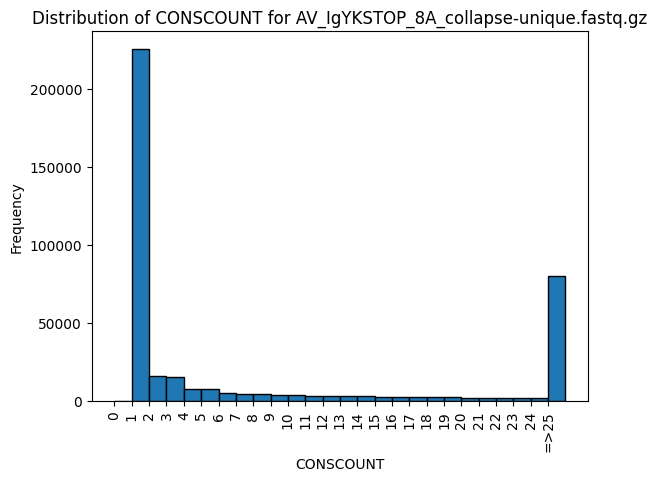

In [4]:
passenger.umi_histogram(fastq_path, 25)


In [5]:
blast_df = passenger.blast_df_of_blast_files([blast_path])

processed_stop_df = chigy.processed_stop_df_of_blast_df(blast_df)
processed_stop_df

,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,...,dataset,sequence,gap_segment_count,bookended_by_gaps,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
0,GGAAACACGCACAAAAC|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,35,54,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGT...,2,True,"[240, 274]","[A, G]",[],2,0,0
1,ATTGGAGGGAAATACGG|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,62,81,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCAT...,2,True,"[226, 240, 274]","[T, A, G]",[],3,0,1
2,AAAGATTGTGAACACAC|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,78,97,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGA...,2,True,[5],[C],[],1,0,2
3,GTCCCTTTACGTGGCTG|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,37,56,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTG...,2,True,[192],[C],[],1,0,3
4,GATAAATCGAATAATAT|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,57,76,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,2,True,"[122, 254, 318]","[T, A, C]",[],3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,TAGGTACTGATAAGAGC|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,79,98,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,2,True,"[97, 319]","[G, T]",[],2,0,8828
8829,AATGGGCGCAACAGGCA|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,57,76,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,5,False,"[2, 3, 4, 6, 8, 9, 14, 15, 16, 17, 23, 25, 27,...","[T, C, C, C, C, T, C, A, G, C, G, G, C, G, G, ...",[],88,0,8829
8830,ATTTGACAATGACATGC|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,79,98,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,2,True,[],[],[],0,0,8830
18935,CAGTTACCACCTCAAGT|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,0,1,1,20,81,99,17.00000,...,AV_IgYKSTOP_8A_collapse-unique,GGCAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAG...,8,False,"[1, 4, 7, 8, 10, 15, 23, 25, 27, 28, 30, 31, 3...","[G, C, C, C, G, A, G, G, C, G, G, C, C, T, C, ...",[],84,0,18935


In [6]:
chigy.pretty_print_alignments(processed_stop_df.head())

> AV_IgYKSTOP_8A_collapse-unique 0
---------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC----------
                                                               ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||          
GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCA

In [7]:
# Group by 'dataset' and count the number of rows in each group
row_counts_by_dataset = processed_stop_df.groupby('dataset').size()

# Print the count of rows for each 'dataset'
print(row_counts_by_dataset)


dataset
AV_IgYKSTOP_8A_collapse-unique    8749
dtype: int64


In [8]:
processed_stop_df["mutation_count"].value_counts()[:20].sort_index()

mutation_count
0      261
1     1450
2     1735
3     1407
4      922
5      587
6      390
7      236
8      144
9       82
10      67
79      34
85      46
86      66
87      97
88     120
89     141
90     127
91      97
92      66
Name: count, dtype: int64

In [9]:
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] < max_mutation_count) & (processed_stop_df["n_count"] < max_n_count) & (processed_stop_df["bookended_by_gaps"] == True)].copy()

chigy_believable


,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,...,dataset,sequence,gap_segment_count,bookended_by_gaps,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
0,GGAAACACGCACAAAAC|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,35,54,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGT...,2,True,"[240, 274]","[A, G]",[],2,0,0
1,ATTGGAGGGAAATACGG|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,62,81,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCAT...,2,True,"[226, 240, 274]","[T, A, G]",[],3,0,1
2,AAAGATTGTGAACACAC|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,78,97,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGA...,2,True,[5],[C],[],1,0,2
3,GTCCCTTTACGTGGCTG|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,37,56,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTG...,2,True,[192],[C],[],1,0,3
4,GATAAATCGAATAATAT|PRCONS=Mus-p5-IgK|SEQORIENT=...,100.0,20,0,0,1,20,57,76,0.00028,...,AV_IgYKSTOP_8A_collapse-unique,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,2,True,"[122, 254, 318]","[T, A, C]",[],3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,TAAAGAAAAGAAGAATG|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,37,56,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTG...,2,True,[],[],[],0,0,8825
8827,AGGAGAGAATGAGGTCT|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,62,81,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCAT...,2,True,[254],[C],[],1,0,8827
8828,TAGGTACTGATAAGAGC|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,79,98,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,2,True,"[97, 319]","[G, T]",[],2,0,8828
8830,ATTTGACAATGACATGC|PRCONS=Mus-p5-IgK|SEQORIENT=...,95.0,20,1,0,1,20,79,98,0.06800,...,AV_IgYKSTOP_8A_collapse-unique,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,2,True,[],[],[],0,0,8830


In [10]:
# Find representatives of the various gap counts
representative_gap_counts = chigy_believable.drop_duplicates(subset=["gap_segment_count"])
representative_gap_counts = representative_gap_counts.sort_values(by=["gap_segment_count"])
chigy.pretty_print_alignments(representative_gap_counts)

> AV_IgYKSTOP_8A_collapse-unique 0
---------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC----------
                                                               ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||          
GGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCA

In [11]:
chigy_believable = chigy_believable[chigy_believable["gap_segment_count"].isin(allowable_gap_segment_counts)]
chigy_believable["mutation_count"].value_counts().sort_index()

mutation_count
0     257
1    1435
2    1713
3    1371
4     900
5     564
6     371
7     221
8     134
9      77
Name: count, dtype: int64

In [12]:
# Find representatives of the various gap counts
representative_mutation_counts = chigy_believable.drop_duplicates(subset=["mutation_count"])
representative_mutation_counts = representative_mutation_counts.sort_values(by=["mutation_count"])
chigy.pretty_print_alignments(representative_mutation_counts)

> AV_IgYKSTOP_8A_collapse-unique 88
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC----------
                                                                                                                                                                               |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

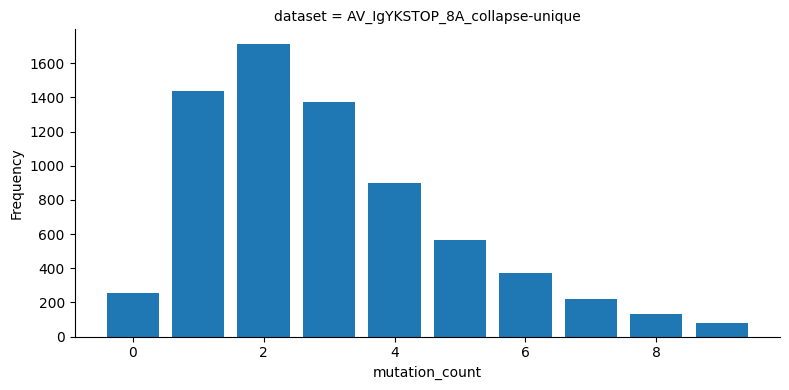

In [13]:
passenger.make_mutation_histogram(chigy_believable)

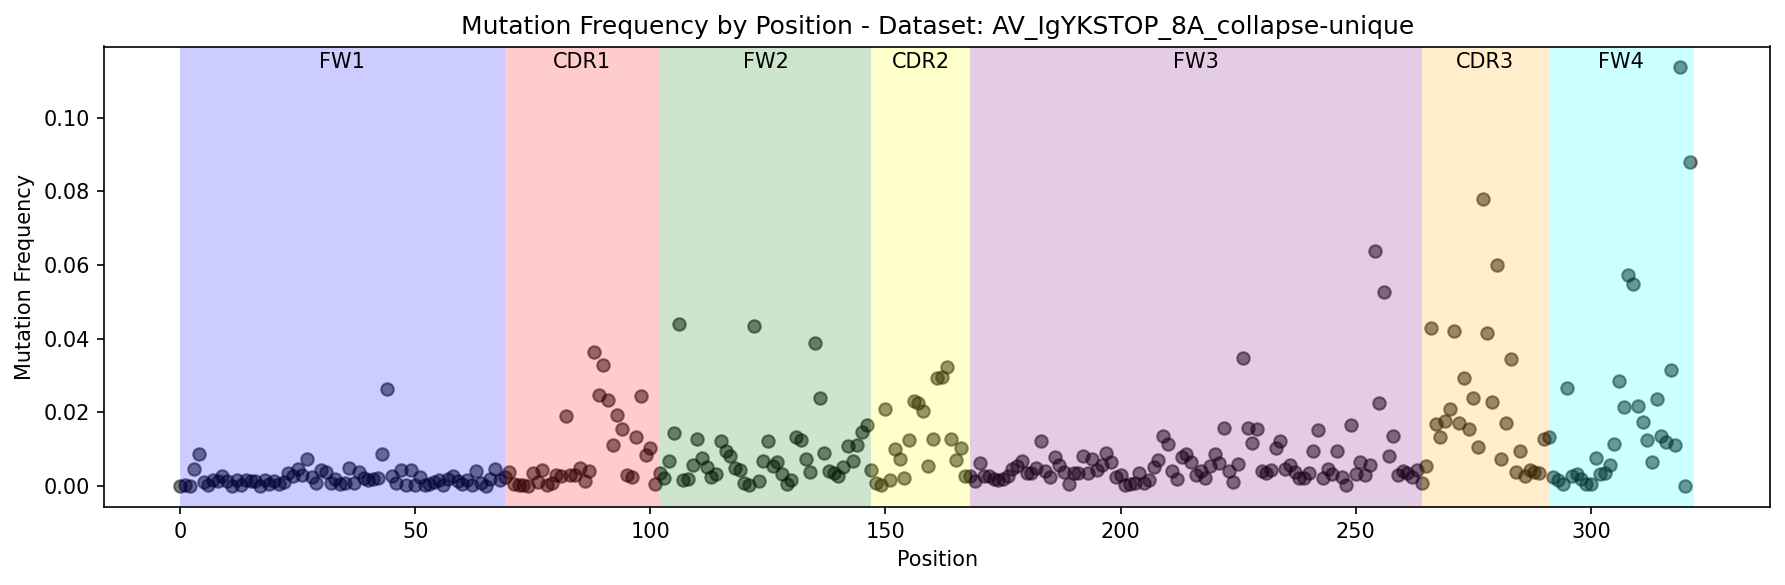

In [14]:
chigy.make_mutation_rate_plot(chigy_believable)


In [15]:
counts_by_base = passenger.compute_mutation_counts_by_base(chigy_believable, chigy.chigy_stop_trimmed)

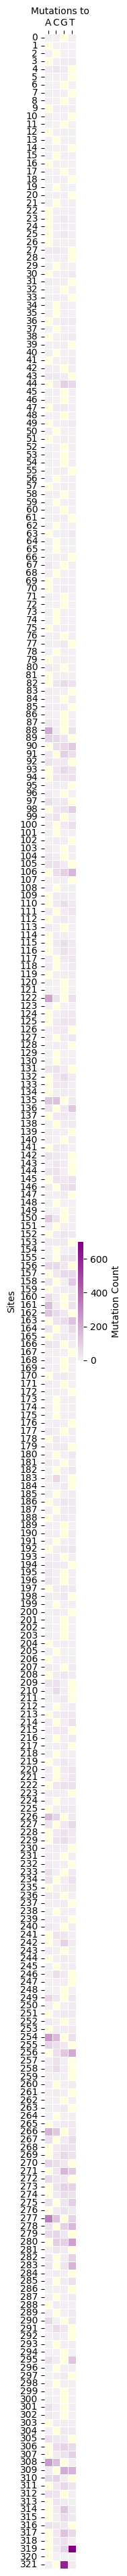

In [16]:
passenger.create_mutation_heatmap(counts_by_base)

In [17]:
counts_by_base.iloc[319]

to_A     -1
to_C     20
to_G     80
to_T    700
Name: 319, dtype: int64

In [18]:
chigy_believable["sequence"].str[-20:].value_counts()


sequence
GAAATAAAACGGGCTGATGC    4911
GAAATAATACGGGCTGATGC     399
GAAATAAAAGGGGCTGATGC     334
GAAATAATAGGGGCTGATGC     125
GAAATGAAACGGGCTGATGC      90
                        ... 
GATTTAAAACGGGCTGATGC       1
GAAATAAAANGGNCTGATGC       1
AAAAAAAAACGGGCTGATGC       1
GAGATAACAGGGGCTGATGC       1
GAAATTACACGGGCTGATGC       1
Name: count, Length: 187, dtype: int64

In [19]:
n_series = pd.DataFrame({"count of Ns": passenger.compute_thing_counts(chigy_believable, "n_positions")}).sort_values(by="count of Ns", ascending=False)
# set the index name of n_series to be "site"
n_series.index.name = "site"
n_series

,count of Ns
site,
321,248
319,229
295,142
307,76
306,34
...,...
170,0
171,0
172,0


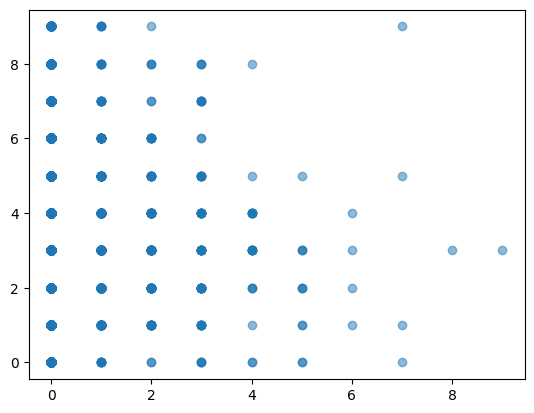

In [20]:
# make a scatter plot of chigy_believable["n_count"] versus chigy_believable["mutation_count"]
plt.scatter(chigy_believable["n_count"], chigy_believable["mutation_count"], alpha=0.5)

In [21]:
padded_seq = "NN" + chigy.chigy_stop_trimmed + "NN"

fivemers = [padded_seq[i:i+5] for i in range(len(padded_seq) - 4)]

pd.DataFrame({"fivemers": fivemers}).to_csv("fivemers.csv", index=False)

In [22]:
mutation_frequency_by_position = passenger.mutation_frequency_by_position_of(chigy_believable)
pd.DataFrame({mut_freq_name: mutation_frequency_by_position}).to_csv(mut_freq_name+".csv", index=False)